In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [19]:
dataset_renaming = {
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
}

subset_renaming = {
    "nonexonic_AND_distal": "Non-exonic (distal)",
    "nonexonic_AND_proximal": "Non-exonic (proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}

In [20]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    "nonexonic_AND_distal",
    "nonexonic_AND_proximal",
    "5_prime_UTR_variant",
    "3_prime_UTR_variant",
    "non_coding_transcript_exon_variant",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    "GPN",
    "Enformer",
    "Borzoi",
]

palette = {model: sns.color_palette("tab10")[i] for i, model in enumerate(models)}

def get_model_path(model, modality, dataset, subset):
    supervised_suffix = "LogisticRegression.chrom"
    if model == "CADD":
        predictor = "CADD.plus.RawScore" if modality == "Zero-shot" else f"CADD.{supervised_suffix}"
    elif model in ["Enformer", "Borzoi"]:
        predictor = f"{model}_L2_L2.plus.all" if modality == "Zero-shot" else f"{model}.{supervised_suffix}"
    elif model == "Ensemble":
        if "mendelian" in dataset:
            prefix = "OMIM_Ensemble_v2" 
        else:
            prefix = "Enformer+GPN-MSA+CADD"
        predictor = f"{prefix}.{supervised_suffix}"
    else:
        if "mendelian" in dataset:
            llr_version = "LLR"
            sign = "minus"
        elif "gwas" in dataset:
            llr_version = "absLLR"
            sign = "plus"
        predictor = f"{model}_{llr_version}.{sign}.score" if modality == "Zero-shot" else f"{model}_{llr_version}+InnerProducts.{supervised_suffix}"
    #return f"../../results/dataset/{dataset}/metrics/{subset}/{predictor}.csv"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"
    #return f"../../results/dataset/{dataset}/metrics_by_chrom/{subset}/{predictor}.csv"

In [25]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([dataset, subset, modality, model, df["score"], df["se"]])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,CADD,0.839602,0.000000
1,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,GPN-MSA,0.824670,0.000000
2,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,GPN,0.177014,0.000000
3,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,Enformer,0.331308,0.000000
4,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,Borzoi,0.351558,0.000000
...,...,...,...,...,...,...
95,gwas_matched_9,non_coding_transcript_exon_variant,Linear probing,CADD,0.305460,0.045432
96,gwas_matched_9,non_coding_transcript_exon_variant,Linear probing,GPN-MSA,0.399139,0.037780
97,gwas_matched_9,non_coding_transcript_exon_variant,Linear probing,GPN,0.215596,0.031541
98,gwas_matched_9,non_coding_transcript_exon_variant,Linear probing,Enformer,0.371131,0.053039


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

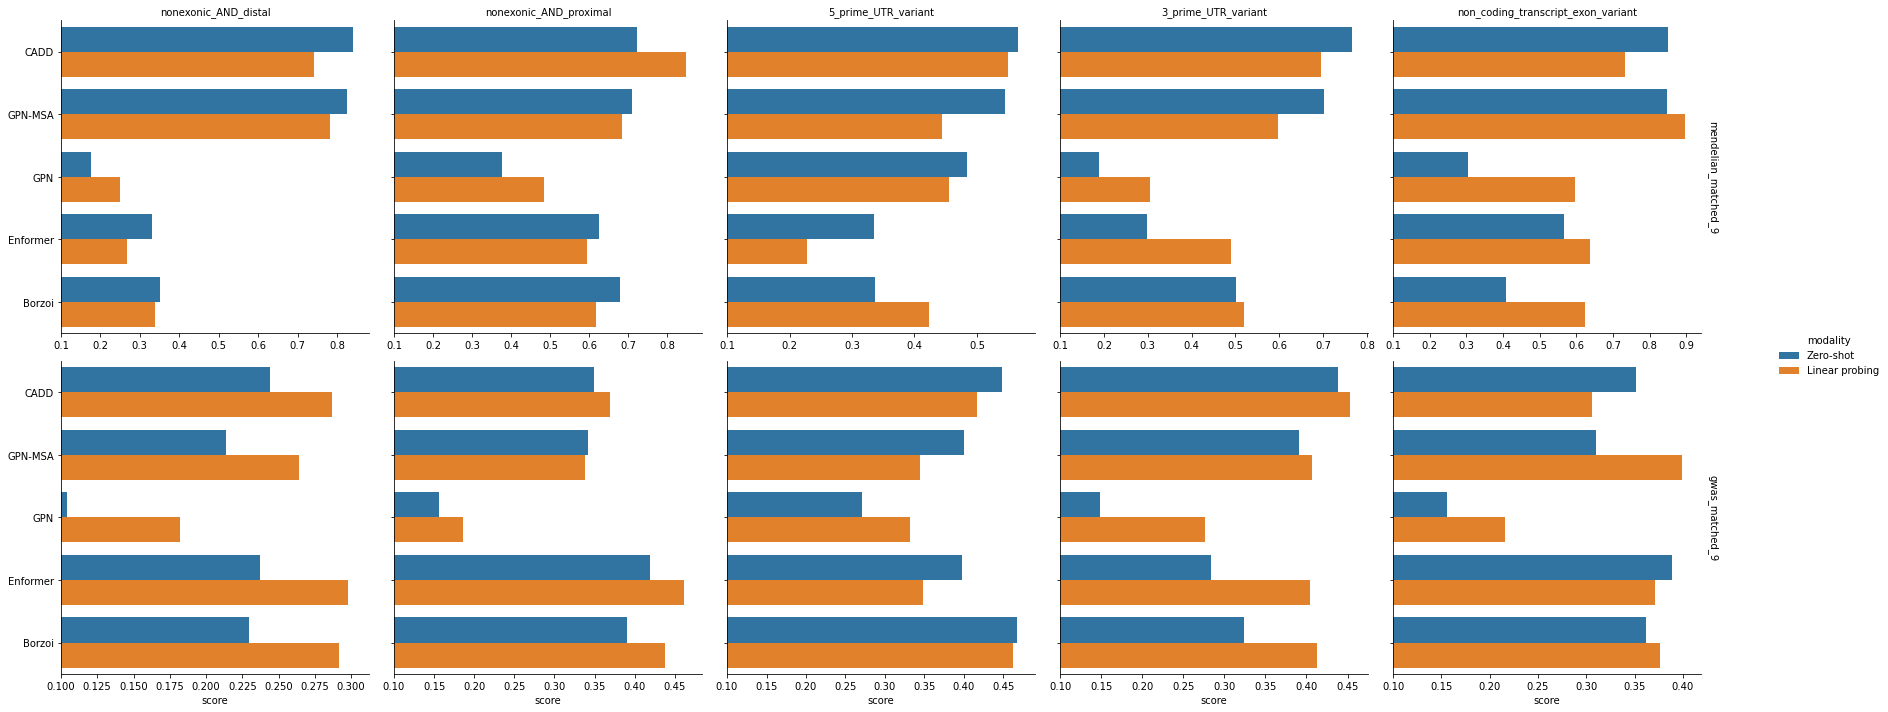

In [31]:
g = sns.catplot(
    data=df,
    y="model",
    x="score",
    hue="modality",
    col="subset",
    row="dataset",
    kind="bar",
    margin_titles=True,
    sharex=False,
    sharey=True,
    #height=2.0,
    #aspect=1.5,
)
g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

In [8]:
dfs = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path)
                df["dataset"] = dataset_renaming.get(dataset, dataset)
                df["subset"] = subset_renaming.get(subset, subset)
                df["modality"] = modality
                df["model"] = model
                dfs.append(df)
df = pd.concat(dfs)
df

,chrom,n,Model,AUPRC,dataset,subset,modality,model
0,1,736,CADD.plus.RawScore,0.222121,Complex traits,Non-exonic (distal),Zero-shot,CADD
1,10,463,CADD.plus.RawScore,0.314736,Complex traits,Non-exonic (distal),Zero-shot,CADD
2,11,485,CADD.plus.RawScore,0.201281,Complex traits,Non-exonic (distal),Zero-shot,CADD
3,12,437,CADD.plus.RawScore,0.321137,Complex traits,Non-exonic (distal),Zero-shot,CADD
4,13,190,CADD.plus.RawScore,0.323786,Complex traits,Non-exonic (distal),Zero-shot,CADD
...,...,...,...,...,...,...,...,...
13,16,40,Borzoi.LogisticRegression.chrom,0.230175,Complex traits,ncRNA,Linear probing,Borzoi
14,17,30,Borzoi.LogisticRegression.chrom,0.125000,Complex traits,ncRNA,Linear probing,Borzoi
15,18,10,Borzoi.LogisticRegression.chrom,1.000000,Complex traits,ncRNA,Linear probing,Borzoi
16,19,30,Borzoi.LogisticRegression.chrom,0.505495,Complex traits,ncRNA,Linear probing,Borzoi


ValueError: Could not interpret input 'score'

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

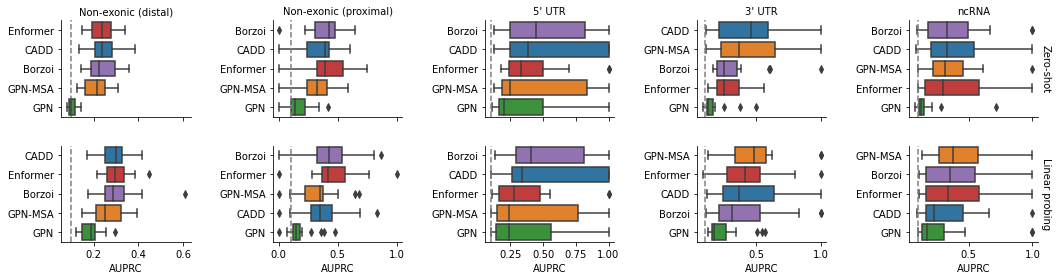

In [11]:
g = sns.FacetGrid(
    df,
    col="subset",
    row="modality",
    margin_titles=True,
    sharex="col",
    sharey=False,#"row",
    height=2.0,
    aspect=1.5,
)

def my_boxplot(data, **kwargs):
    ax = plt.gca()
    sns.boxplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        order=data.groupby("model")["AUPRC"].median().sort_values(ascending=False).index,
        palette=palette,
    )
    ax.axvline(x=0.1, color="grey", linestyle="--")

g.map_dataframe(my_boxplot)

g.set(
    ylabel="",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

In [6]:
df.dataset = df.dataset.map({
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
})
df.subset = df.subset.map({
    "nonexonic_AND_distal": "Non-exonic (distal)",
    "nonexonic_AND_proximal": "Non-exonic (proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
})

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

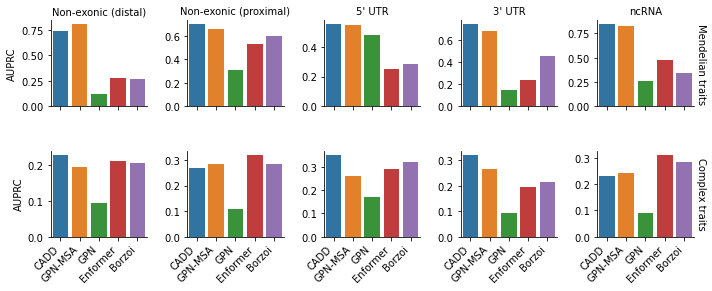

In [37]:
# TODO: add error bars

g = sns.catplot(
    data=df.rename(columns={"score": "AUPRC"}),
    x="model",
    y="AUPRC",
    row="dataset",
    col="subset",
    kind="bar",
    sharey=False,
    margin_titles=True,
    height=2,
)
g.set(
    xlabel="",
)
for ax in g.axes[-1, :]:  # Select only the last row
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.set_titles(col_template="{col_name}", row_template="{row_name}");